Dataset from source https://github.com/ekapope/Predicting-condominium-price-using-data-from-webscraping

In [1270]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mimg 
import seaborn as sns
import random

from math import radians, sqrt, sin, cos, atan2, trunc, ceil
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, SGDRegressor, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor

In [1201]:
condo_df = pd.read_csv("Dataset/df_cleaned_for_ML_regression.csv")
condo_df.head()

,name,district,latitude,longitude,year_built,proj_area,nbr_buildings,nbr_floors,units,hospital,...,tran_name1,tran_name2,tran_name3,tran_name4,tran_name5,dist_tran_1,dist_tran_2,dist_tran_3,dist_tran_4,dist_tran_5
0,101 Mansion,Bang Kapi,13.787435,100.631564,1991,23371,5,5,834.0,2.10,...,Lat Phrao Toll Plaza,Yothin Phatthana Toll Plaza,Pracha Uthit Toll Plaza,Sutthisan,Huai Khwang,4.3,4.8,5.0,8.1,8.3
1,624 Condolette Ladprao,Bang Kapi,13.766348,100.649395,2011,6476,2,8,471.0,1.80,...,Lat Phrao Toll Plaza,Srinagarindra Toll Plaza,Pracha Uthit Toll Plaza,Huai Khwang,Thailand Cultural Centre,5.8,6.2,6.5,9.8,9.9
2,Adamas Ramkhamhaeng,Bang Kapi,13.752448,100.615507,1995,4699,1,16,140.0,2.30,...,Srinagarindra Toll Plaza,Ramkhamhaeng Toll Plaza,Phatthanakan 2 Toll Plaza,Phra Khanong,Ekkamai,2.1,2.5,2.9,6.1,6.3
3,Aspire Ladprao 113,Bang Kapi,13.770286,100.638799,2016,3816,1,8,270.0,0.68,...,Lat Phrao Toll Plaza,Pracha Uthit Toll Plaza,Srinagarindra Toll Plaza,Sutthisan,Huai Khwang,4.7,5.4,6.1,8.5,8.7
4,B.R. Condo,Bang Kapi,13.768706,100.638876,1991,7391,2,10,560.0,0.69,...,Lat Phrao Toll Plaza,Pracha Uthit Toll Plaza,Srinagarindra Toll Plaza,Sutthisan,Huai Khwang,4.7,5.4,6.1,8.5,8.6


In [1202]:
condo_df.columns

Index(['name', 'district', 'latitude', 'longitude', 'year_built', 'proj_area',
       'nbr_buildings', 'nbr_floors', 'units', 'hospital', 'price_sqm', 'id',
       'bld_age', 'dist_shop_1', 'dist_shop_2', 'dist_shop_3', 'dist_shop_4',
       'dist_shop_5', 'dist_school_1', 'dist_school_2', 'dist_school_3',
       'dist_school_4', 'dist_school_5', 'dist_food_1', 'dist_food_2',
       'dist_food_3', 'dist_food_4', 'dist_food_5', 'Elevator', 'Parking',
       'Security', 'CCTV', 'Pool', 'Sauna', 'Gym', 'Garden', 'Playground',
       'Shop', 'Restaurant', 'Wifi', 'tran_type1', 'tran_type2', 'tran_type3',
       'tran_type4', 'tran_type5', 'tran_name1', 'tran_name2', 'tran_name3',
       'tran_name4', 'tran_name5', 'dist_tran_1', 'dist_tran_2', 'dist_tran_3',
       'dist_tran_4', 'dist_tran_5'],
      dtype='object')

### Amount of highest count Condominius per district and their mininmum, maximum, average price per sqm

In [1476]:
top_df = condo_df.groupby('district')['price_sqm'].describe().sort_values(by='count', ascending=False)[['count' ,'mean' ,'min' ,'max']][:10]
condo_top = []
condo_top.append(top_df.index)
for i in range(4):
    condo_top.append(np.round(top_df).astype(int).values[:,i]) 
    
top_df['district'] = top_df.index.values

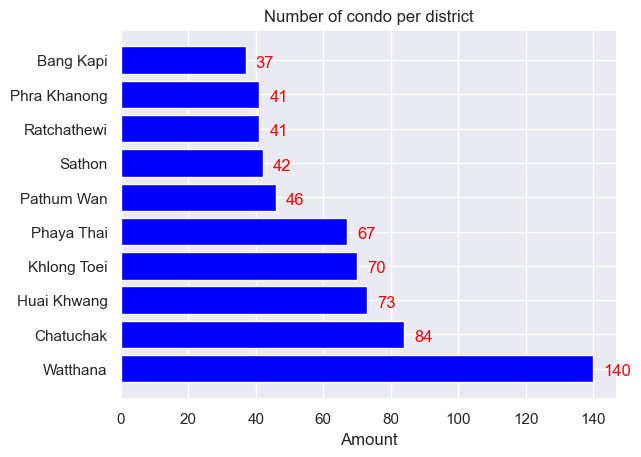

In [1478]:
plt.barh(top_df['district'], top_df['count'], color='blue')

for i, v in enumerate(top_df['count']):
    plt.text(v + 3, i -.2, str(int(v)), color='red', fontweight='light')
    
plt.xlabel('Amount') 
plt.title('Number of condo per district')
plt.show()

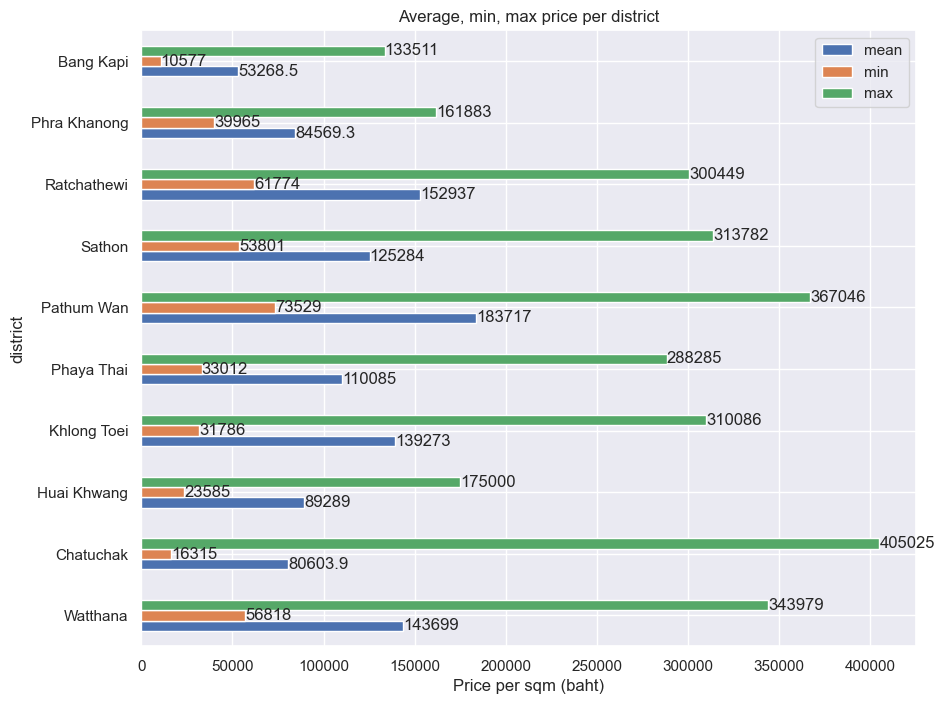

In [1483]:
ax = top_df.plot.barh(y=['mean', 'min', 'max'], x='district', figsize=(10,8))

for container in ax.containers:
    ax.bar_label(container)

plt.xlabel('Price per sqm (baht)') 
plt.title('Average, min, max price per district')
plt.legend()
plt.show()

### Haversine function to calculate distance between two points on a  sphere (earth) as longitudes and latitudes

In [1204]:
def haverSine(lat1,lon1,lat2,lon2):
    R = 6371e3
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    alon = lon2 - lon1
    alat = lat2 - lat1

    a = sin(alat/2)**2 + cos(lat1) * cos(lat2) * sin(alon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    d = R * c

    return d

In [1205]:
lat_min = np.round(condo_df['latitude'].min(),6) #- 0.001
lat_max= np.round(condo_df['latitude'].max(),6) #+ 0.001
long_min = np.round(condo_df['longitude'].min(),6) #- 0.001
long_max = np.round(condo_df['longitude'].max(),6) #+ 0.001

# Calculate from latitude and longitude point as rectangle
dist_map = haverSine(lat_min, long_min, lat_max, long_max)
print("Distance from providing coordinate data:", round(dist_map/1000,2), "km")

# Calculate total grid need for the whole map
verticle_offset = haverSine(lat_min,long_min,lat_max,long_min)
row = round(verticle_offset/1000)

horizontal_offset = haverSine(lat_min,long_min,lat_min,long_max)
col = round(horizontal_offset/1000)

print('Row: '+ str(row) + ' Col: ' + str(col))

Distance from providing coordinate data: 48.07 km
Row: 30 Col: 38


In [1206]:
# Store coordinate of condos for calculate distance from top left of map to count amount of condo in one grid 
condo_cor = condo_df[['longitude', 'latitude']].to_numpy()

bkk_grid = np.zeros(row*col)

for point in condo_cor:
    # use haverSine to calculate offset of from lat and long
    verticle_offset = haverSine(lat_max, long_min, point[1], long_min)
    horizontal_offset = haverSine(lat_max, long_min, lat_max, point[0])

    # assign grid number
    grid_number = ( (round(verticle_offset/1000) * (col)) + round(horizontal_offset/1000) )
    
    # count the amount of condos in one grid
    if(grid_number <= row * col):
        bkk_grid[grid_number-1] += 1
    else:
        print(grid_number)

1167


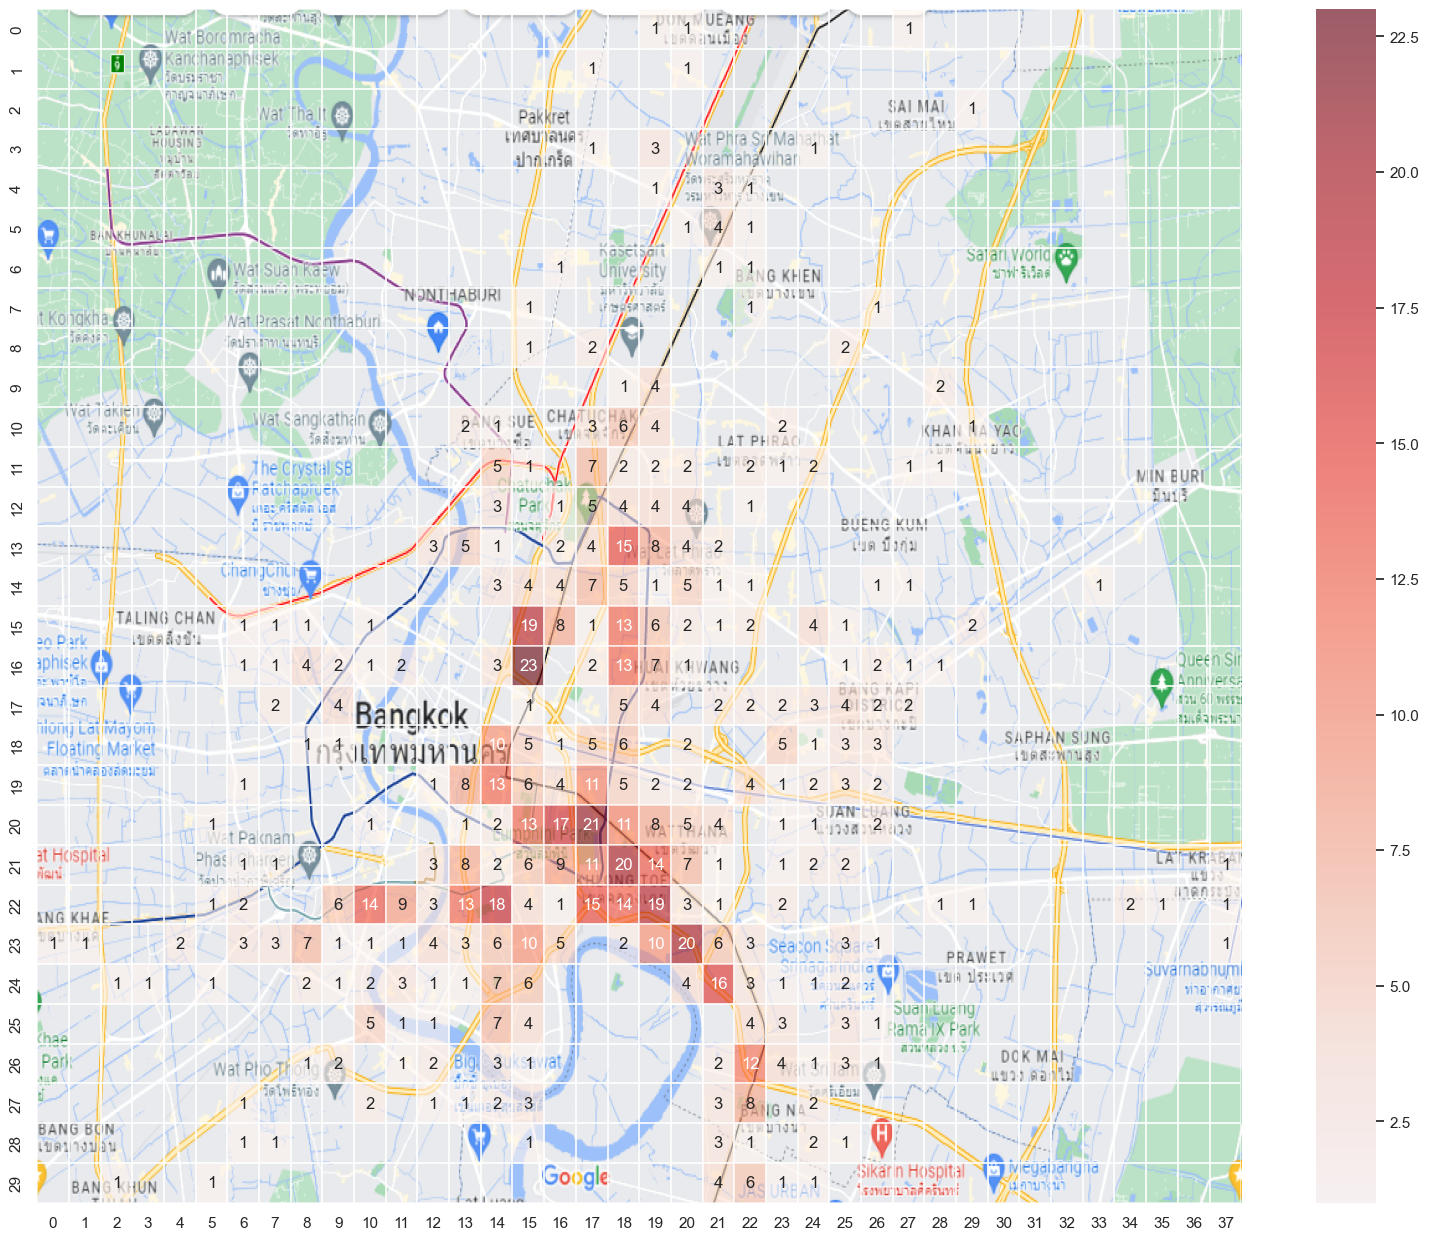

In [1207]:
map_img = mimg.imread('bangkok_map.png') 
my_dpi=100.
fig = plt.figure(figsize=(float(map_img.shape[1])/(my_dpi/2),float(map_img.shape[0])/(my_dpi/2)),dpi=my_dpi)
#ax=fig.add_subplot(111)
#width,height = map_img.shape[1],map_img.shape[0]
# Remove whitespace from around the image
#fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
# Set the gridding interval
#ax.xaxis.set_major_locator(plticker.MultipleLocator(width/col))
#ax.yaxis.set_major_locator(plticker.MultipleLocator(height/row))
# Set x,y lims
#plt.setp(ax, xticklabels=[i for i in range(-1,col+1,1)], yticklabels=[i for i in range(row+1,0,-1)])   
# Add the grid
#ax.grid(which='major', axis='both', linestyle='-')

# Eliminate 0 value with nan, so it doesn't show in heatmap
bkk_grid[bkk_grid == 0] = np.nan
heatmap_bkk = bkk_grid.reshape(row, col)

sns.set()
hmax = sns.heatmap(heatmap_bkk,
            cmap = matplotlib.cm.Reds,
            alpha = 0.6, # heatmap translucent adjustment
            annot = True,
            linewidth=.1,
            zorder = 2,)

hmax.imshow(map_img,
          aspect = hmax.get_aspect(),
          extent = hmax.get_xlim() + hmax.get_ylim(),
          zorder = 1) #put the map under the heatmap

As the grid map show the density of condominium in 1 km square, the centre area of bangkok has a higher amount while the number decrease when go furthur. Also, the public transportation like subway (BTS,MRT) show that along the transportation line there are high density of condominium as it comfortable to transport via BTS/MRT line in city that heavily affect by traffic jam.

### Check latitude/longitude is place corretly on grid map

In [1208]:
# Grid Number 20 (index 313)
condo_df.iloc[313][['name','latitude','longitude']]

name         P.P.H. Condo
latitude        13.917463
longitude      100.580911
Name: 313, dtype: object

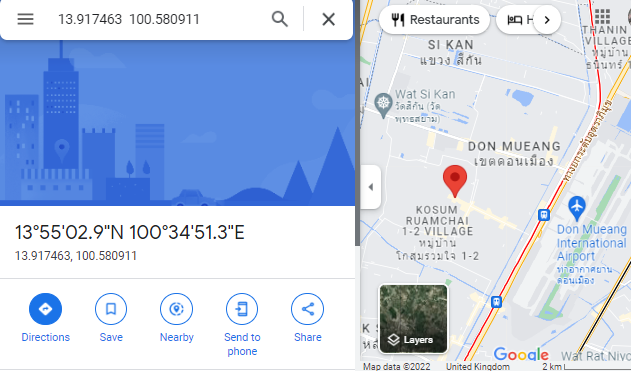

In [1209]:
# Grid Number 106 (index 737)
condo_df.iloc[737][['name','latitude','longitude']]

name         Keha Chunchon Orngern
latitude                 13.907001
longitude               100.673558
Name: 737, dtype: object

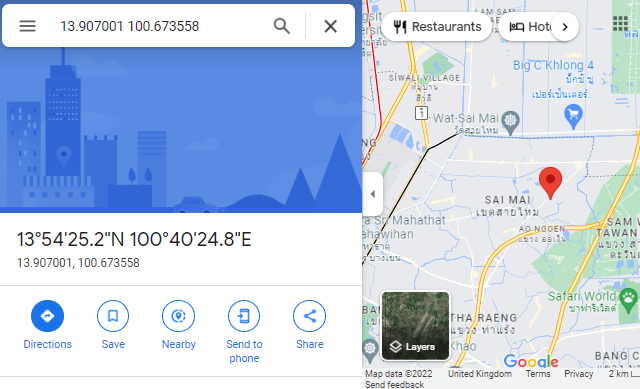

### Compare with grid map image

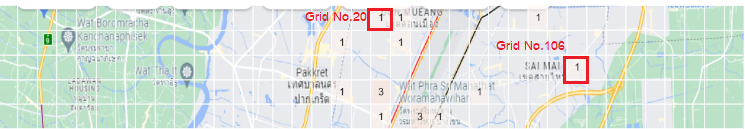

Text(0.5, 1.0, 'Number of condos built in year range')

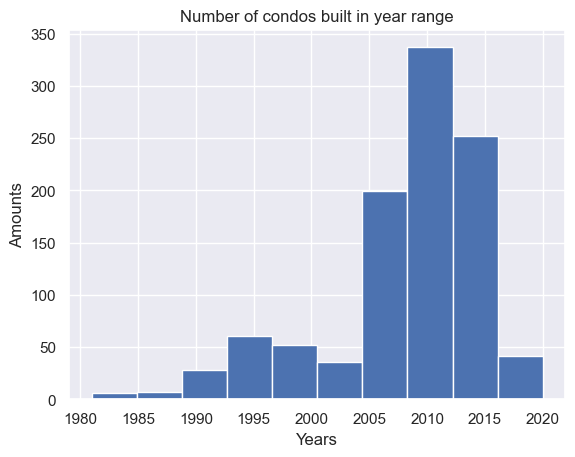

In [1210]:
counts, bins = np.histogram(condo_df['year_built'], bins=10)
plt.hist(bins[:-1], bins, weights=counts)

plt.xlabel('Years')
plt.ylabel('Amounts')
plt.title("Number of condos built in year range")

### Selected columns that will calculate in regression

In [1211]:
selected_column_df = condo_df[['latitude', 'longitude', 'proj_area',
       'nbr_buildings', 'nbr_floors', 'units', 'hospital', 'price_sqm', 
        'bld_age', 'dist_tran_1', 'Elevator', 'Parking',
       'Security', 'CCTV', 'Pool', 'Sauna', 'Gym', 'Garden', 'Playground',
       'Shop', 'Restaurant', 'Wifi', 'tran_type1']].copy()

### Check correlation of price_sqm to each numeric columns

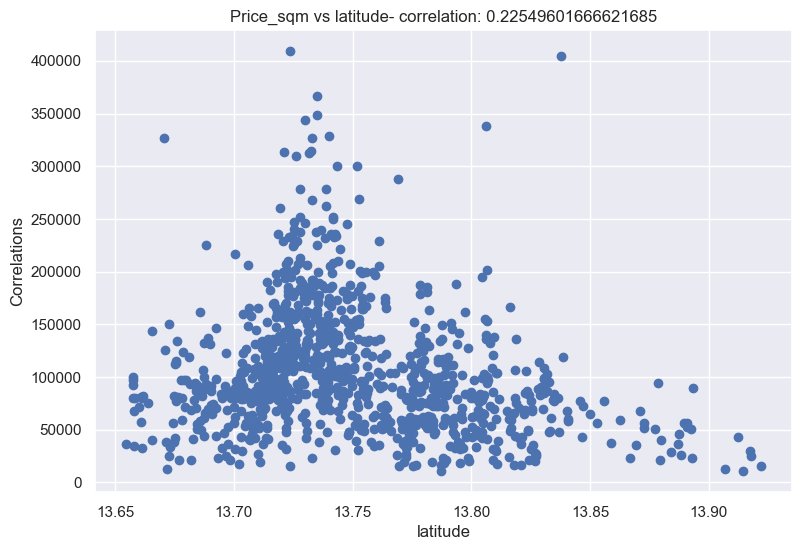

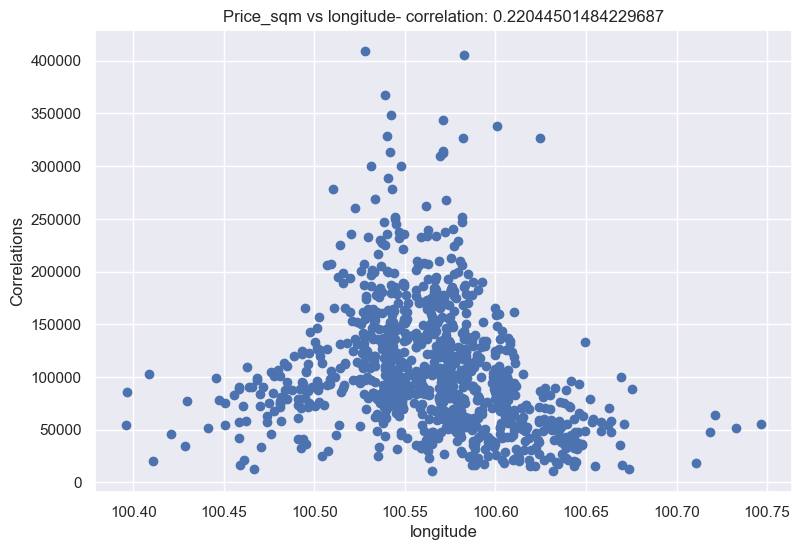

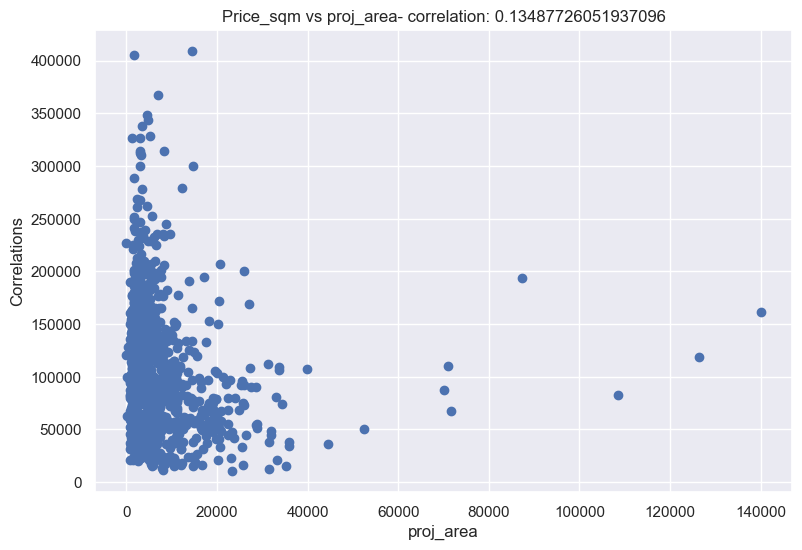

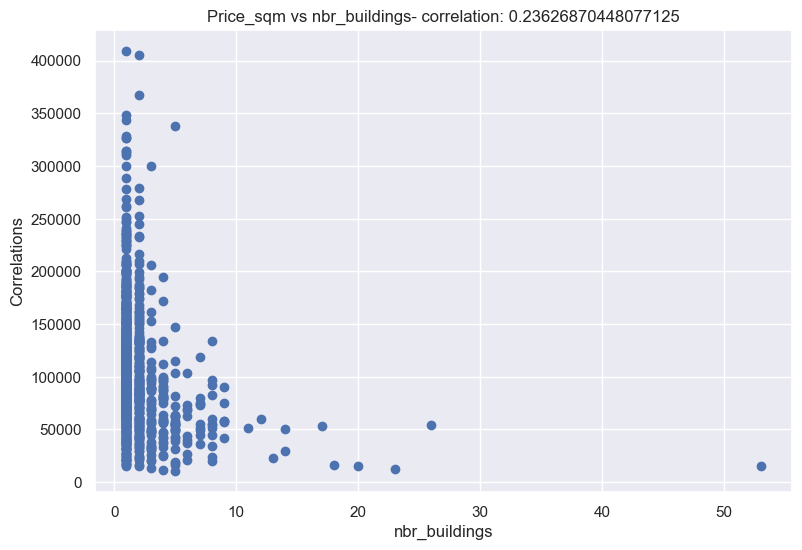

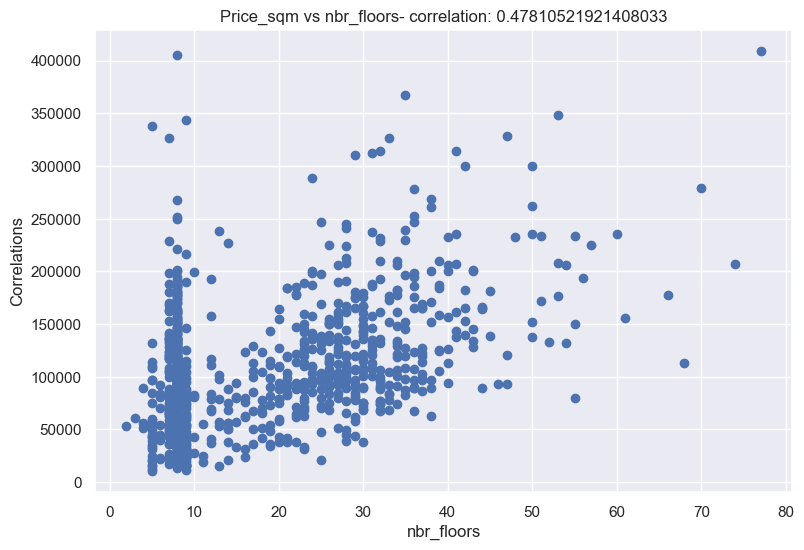

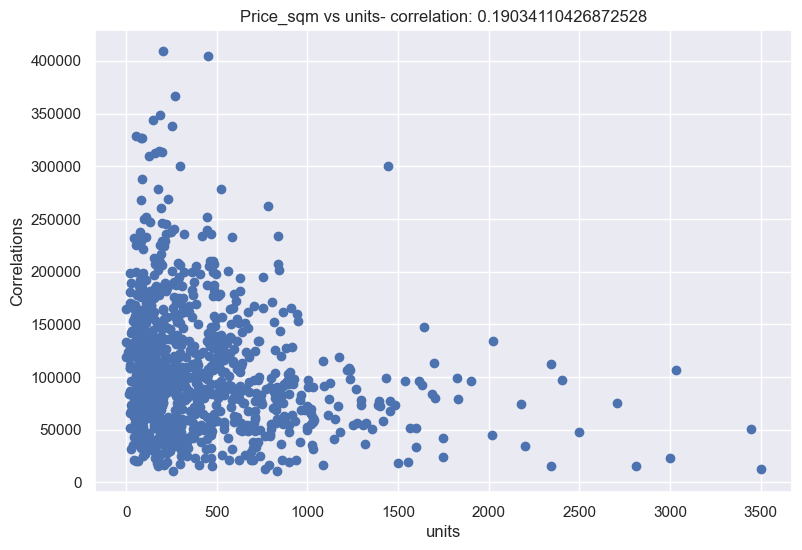

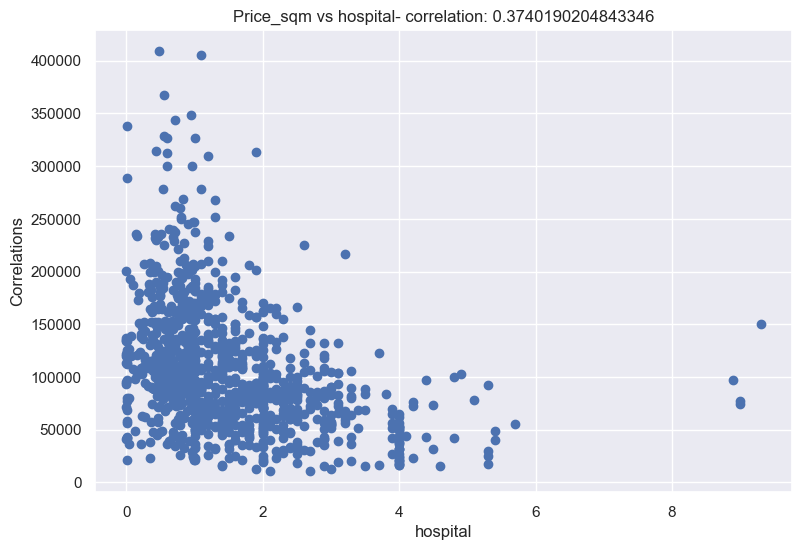

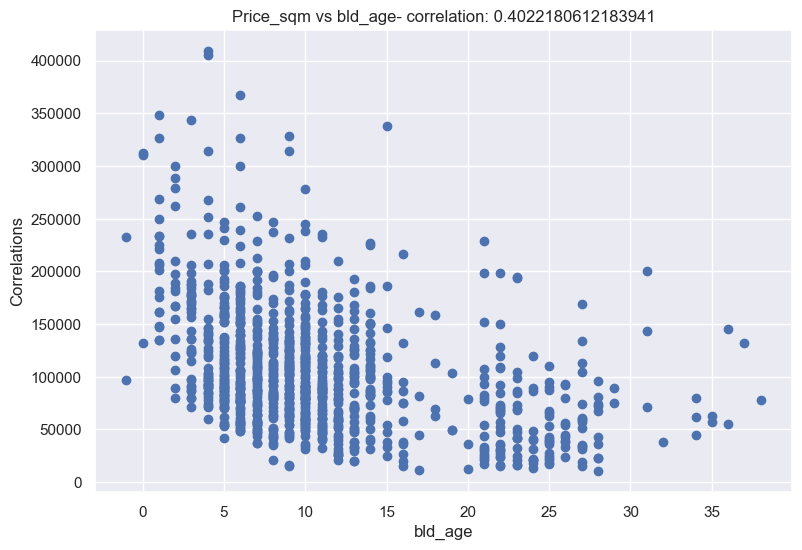

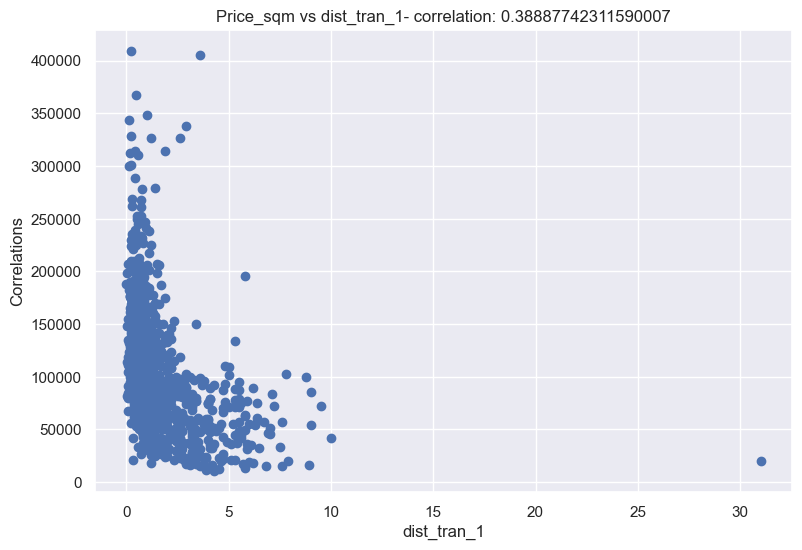

In [1212]:
label = selected_column_df['price_sqm']

for col in selected_column_df[['latitude', 'longitude','proj_area', 'nbr_buildings', 'nbr_floors', 'units', 'hospital', 'bld_age', 'dist_tran_1']]:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = selected_column_df[col]
    correlation = np.abs(feature.corr(label))
    plt.scatter(x=feature, y=label)
    plt.xlabel(col)
    plt.ylabel('Correlations')
    ax.set_title('Price_sqm vs ' + col + '- correlation: ' + str(correlation))
plt.show()

In [1213]:
# Remove outlier
q_high = selected_column_df['price_sqm'].quantile(0.985)

selected_df = selected_column_df[selected_column_df['price_sqm'] < q_high]

In [1214]:
# Onehot Encode transportation type and rearrange columns
onehot_encoder = OneHotEncoder(sparse=False)
encoder_df = pd.DataFrame( np.asarray(onehot_encoder.fit_transform(selected_column_df[['tran_type1']])), columns=[i for i in np.sort(selected_column_df['tran_type1'].unique())])

final_df = selected_column_df.join(encoder_df)

final_df = final_df.drop('tran_type1',axis=1)

column_move = final_df.pop('price_sqm')
final_df.insert(len(final_df.columns), 'price_sqm', column_move)

### Scale only numeric features

In [1215]:
col_names = ['latitude', 'longitude', 'proj_area', 'nbr_buildings', 'nbr_floors', 'units', 'hospital', 'bld_age','dist_tran_1']
features = final_df[col_names]

# Combine preprocessing steps
preprocessor = ColumnTransformer([
        ('scaler', StandardScaler(), ['latitude', 'longitude', 'proj_area', 'nbr_buildings', 'nbr_floors', 'units', 'hospital', 'bld_age', 'dist_tran_1'])
    ], remainder='passthrough')

scale_X = preprocessor.fit_transform(features)

In [1216]:
X, y = np.hstack((scale_X,final_df[final_df.columns[9:-1]].to_numpy())), final_df[final_df.columns[-1]].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=44)
print ('Training Set: %d, rows\nTest Set: %d rows' % (X_train.shape[0], X_test.shape[0]))

Training Set: 713, rows
Test Set: 306 rows


### Function calcualte score and plot graph for each model

In [1220]:
def score_performance(model, X_train, y_train, X_test, y_test):
    kfold = KFold(5, shuffle=True, random_state=55)
    rmse_train= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=kfold))
    r2_train= cross_val_score(model, X_train, y_train, scoring="r2", cv=kfold)
    y_pred = model.predict(X_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
    r2_test = r2_score(y_test, y_pred)
    print('RMSE test: %.f'%rmse_test,'r2_score test: %.4f'%r2_test)
    return y_pred, rmse_train, r2_train, rmse_test, r2_test

def plot_pred_actual(true, pred, model_name):
    plt.scatter(true, pred)    
    plt.xlabel("True prices")
    plt.ylabel("Prediction prices")
    plt.title('Prediction vs Actual for '+ model_name)
    p = np.poly1d(np.polyfit(true, pred, 1))
    plt.plot(true,p(true), color='red')
    plt.show()
    
def plot_importances_feature(model, df, num):
    plt.figure(figsize=(10,7))
    feat_importances = pd.Series(model.feature_importances_ , index = df[df.columns[0:-1]].columns)
    feat_importances.nlargest(num).plot(kind='barh');
    plt.title('Features Importances')
    plt.show()

### Linear Regression model

In [1221]:
model_linear = LinearRegression()

model_linear = model_linear.fit(X_train, y_train)

RMSE test: 36253 r2_score test: 0.5767


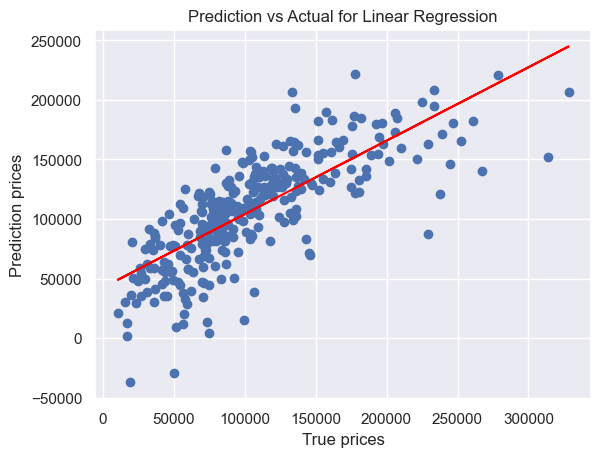

In [1222]:
y_pred, rmse_train_linear, r2_train_linear, rmse_test_linear, r2_test_linear = score_performance(model_linear, X_train, y_train, X_test, y_test)
plot_pred_actual(y_test, y_pred, 'Linear Regression')

### Gradient Boosting Regressor model

In [ ]:
param_grid = {
    'learning_rate': [0.01, 0.02, 0.05],
    'max_depth': [4, 6, 10],
    'subsample'    : [0.1, 0.3, 0.5],
    'min_samples_leaf': [2, 3, 4], 
    'min_samples_split': [2, 4, 8],
    'n_estimators': [100, 400, 600],    
}

model_gradient = GradientBoostingRegressor(random_state=15)
grid_gradient = GridSearchCV(estimator=model_gradient, param_grid=param_grid, 
                          cv=5, n_jobs=-1, verbose=1)

grid_gradient.fit(X_train, y_train)

In [980]:
grid_gradient.best_params_

{'learning_rate': 0.01,
 'max_depth': 10,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 400,
 'subsample': 0.3}

{'learning_rate': 0.01,
 'max_depth': 10,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 400,
 'subsample': 0.3}

In [1225]:
model = GradientBoostingRegressor(random_state = 15,
                                learning_rate= 0.01,
                                loss='huber',
                                max_depth=10,
                                max_features='sqrt',
                                min_samples_leaf=3,
                                min_samples_split=8,
                                n_estimators=400,
                                subsample=0.3)

model = model.fit(X_train, y_train)

RMSE test: 29941 r2_score test: 0.7113


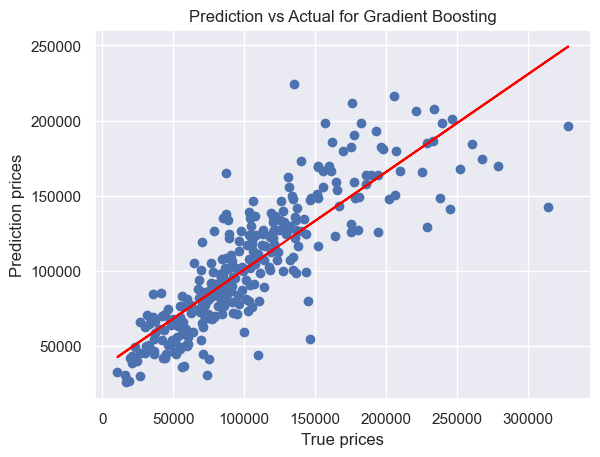

In [1226]:
y_pred, rmse_train_gra, r2_train_gra, rmse_test_gra, r2_test_gra = score_performance(model, X_train, y_train, X_test, y_test)
plot_pred_actual(y_test, y_pred, 'Gradient Boosting')

### SGDRegressor

In [1067]:
param_grid_sgd = {
    'loss': ['squared_error', 'huber'],
    'alpha': [0.0001, 0.001, 0.01,  0.05, 0.1],
    'max_iter': [1000, 2000, 4000],
    'learning_rate': ['constant', 'optimal', 'invscaling'],   
    'power_t'    : [0.1, 0.25, 0.5]
}

sgd = SGDRegressor(random_state=15)
grid_sgd = GridSearchCV(estimator=sgd, param_grid=param_grid_sgd, 
                          cv=5, n_jobs=-1, verbose=1)

grid_sgd.fit(X_train, y_train)

Fitting 5 folds for each of 270 candidates, totalling 1350 fits


GridSearchCV(cv=5, estimator=SGDRegressor(random_state=15), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1],
                         'learning_rate': ['constant', 'optimal', 'invscaling'],
                         'loss': ['squared_error', 'huber'],
                         'max_iter': [1000, 2000, 4000],
                         'power_t': [0.1, 0.25, 0.5]},
             verbose=1)

In [1228]:
grid_sgd.best_params_

{'alpha': 0.1,
 'learning_rate': 'invscaling',
 'loss': 'squared_error',
 'max_iter': 1000,
 'power_t': 0.1}

In [1229]:
model_sgd = SGDRegressor(random_state=15,
                                alpha= 0.1,
                                learning_rate='invscaling',
                                loss='squared_error',
                                max_iter=1000,
                                power_t=0.1
                                )

model_sgd = model_sgd.fit(X_train, y_train)

RMSE test: 36377 r2_score test: 0.5738


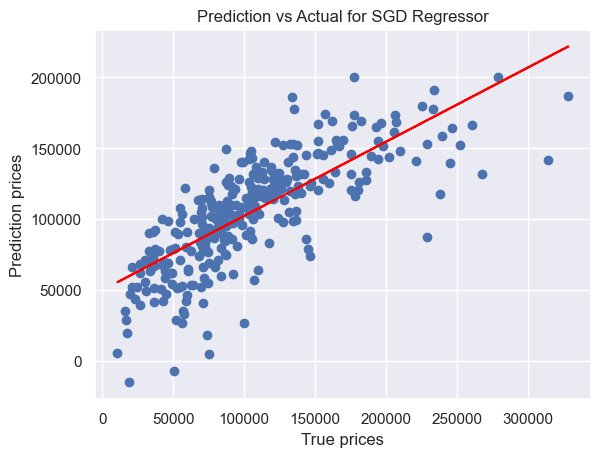

In [1230]:
y_pred, rmse_train_sgd, r2_train_sgd, rmse_test_sgd, r2_test_sgd = score_performance(model_sgd, X_train, y_train, X_test, y_test)
plot_pred_actual(y_test, y_pred, 'SGD Regressor')

### Lasso

In [1178]:
param_grid_lasso={
            'alpha':[0.1, 1, 10, 100],
            'max_iter' : [1000, 2000, 4000],
            'selection':['cyclic', 'random'],
           }

lasso = Lasso(random_state=15)
grid_lasso = GridSearchCV(estimator=lasso, param_grid=param_grid_lasso, 
                          cv=5, n_jobs=-1, verbose=1)

grid_lasso.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=Lasso(random_state=15), n_jobs=-1,
             param_grid={'alpha': [0.1, 1, 10, 100],
                         'max_iter': [1000, 2000, 4000],
                         'selection': ['cyclic', 'random']},
             verbose=1)

In [1231]:
grid_lasso.best_params_

{'alpha': 100, 'max_iter': 1000, 'selection': 'random'}

In [1232]:
model_lasso = Lasso(random_state=15,
                                alpha= 100,
                                max_iter=1000,
                                selection='random'
                                )

model_lasso = model_lasso.fit(X_train, y_train)

RMSE test: 36237 r2_score test: 0.5771


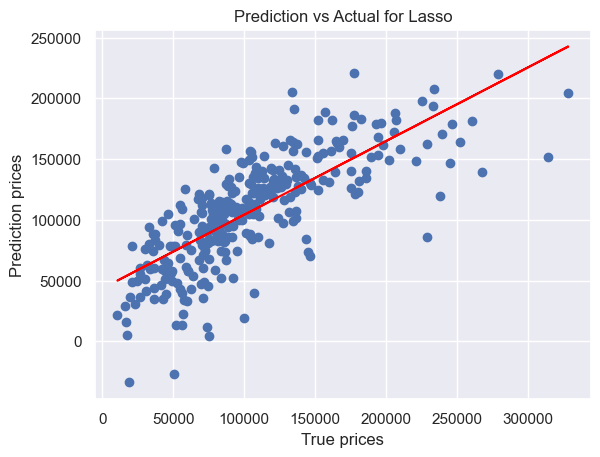

In [1233]:
y_pred, rmse_train_lasso, r2_train_lasso, rmse_test_lasso, r2_test_lasso = score_performance(model_lasso, X_train, y_train, X_test, y_test)
plot_pred_actual(y_test, y_pred, 'Lasso')

### Compare score and performance for each model

In [1260]:
rmse_score = [rmse_test_linear, rmse_test_sgd, rmse_test_gra, rmse_test_lasso]
r2_score = [r2_test_linear, r2_test_sgd, r2_test_gra, r2_test_lasso]
model_name = ['Linear Regression', 'SGD Regressor', 'Gradient Boost Regressor', 'Lasso']

data = {
    'Model Name': model_name,
    'RMSE': rmse_score,
    'R2': r2_score
}

score_df = pd.DataFrame(data)
score_df

,Model Name,RMSE,R2
0,Linear Regression,36253.374209,0.576711
1,SGD Regressor,36377.396029,0.573810
2,Gradient Boost Regressor,29941.162907,0.711280
3,Lasso,36237.452658,0.577083


#### Gradient Boost Regressor acquire lower RMSE and higher R2 score than the rest of model

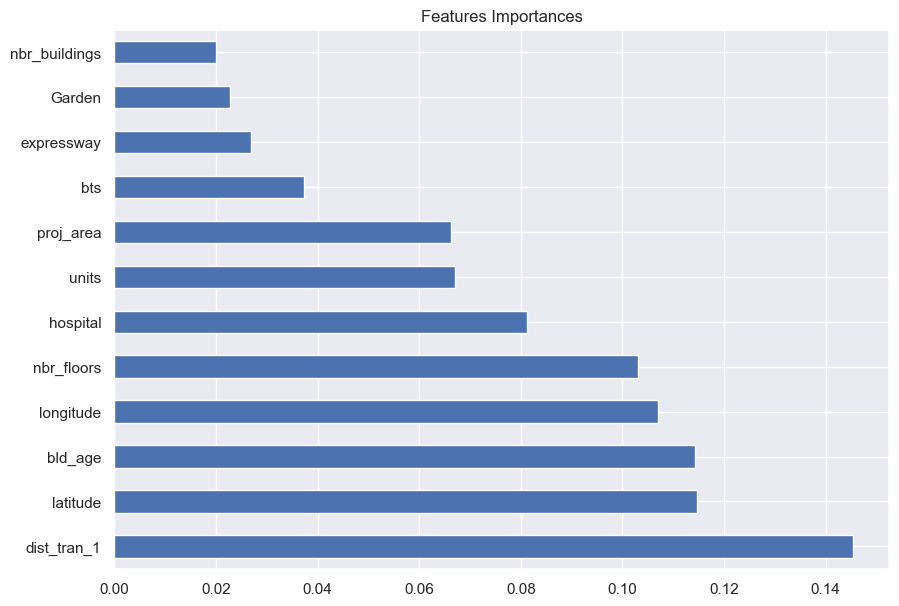

In [1269]:
plot_importances_feature(model, final_df, 12)

<h4> Check the feature importances of Gradient Booster Regressor model to find 12 highest features.</h4>

    
As numeric feature yield very high value except number of buildings, while categorical feature such as transport type bts, expressway have a higher value than the rest of categorical features. These features are useful and indicate the gradient boost regressor model capability in predicting the price/sqm for the condominium.